In [1]:
import os
from torch.utils.data import DataLoader
from dataloader_csv import create_dataloader_csv
import matplotlib.pyplot as plt
from PIL import ImageOps
import torchvision
import numpy as np
import cv2

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import *


device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# CPUデバイスを指定
# device = torch.device("cpu")

print(device)
path = os.getcwd()
path = '/root/notebooks/sample/dataset/CSV_4label'
train_dataloader,test_dataloader,labels=create_dataloader_csv(path,16,None)
print(train_dataloader)

/python/build/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:1
Classification label : {'Lateral': 0, 'Posterior': 1, 'Anterior': 2, 'Inferior': 3}
torch.Size([149, 12, 500])
149
test1
dataset len : 149
data 0: (tensor([[  0.,   0.,  -1.,  ..., -20., -21., -22.],
        [  0.,   0.,   0.,  ..., -46., -47., -48.],
        [  0.,   0.,   1.,  ..., -26., -26., -26.],
        ...,
        [  0.,  -2.,  -4.,  ..., -77., -76., -77.],
        [  0.,  -1.,  -2.,  ..., -62., -62., -63.],
        [  0.,   0.,  -2.,  ..., -52., -52., -53.]], dtype=torch.float64), tensor(0))
labels len : 149
tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

In [3]:
import torch.nn as nn

class RNNmodel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(RNNmodel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # RNNの出力を取得する
        _, hn = self.rnn(x)
        # 最後のタイムステップの隠れ状態を使用して分類を行う
        # output = self.fc(hn.squeeze(0))
        output = self.fc(hn[-1])
        return output
    

class LSTMmodel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(LSTMmodel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # LSTMの出力を取得する
        _, (hn, _) = self.lstm(x)
        # 最後のタイムステップの隠れ状態を使用して分類を行う
        output = self.fc(hn[-1])
        return output

In [4]:
# 各波形ごとにLSTMを適用する

# LSTMモデルの定義
class WaveLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(WaveLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
    
    def forward(self, x):
        output, _ = self.lstm(x)
        return output[:, -1, :]  # 最後のタイムステップの出力を返す
    
# 全体のモデルの定義
class WaveConcatModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_waveforms, output_size):
        super(WaveConcatModel, self).__init__()
        self.lstm_modules = nn.ModuleList([WaveLSTM(input_size, hidden_size) for _ in range(num_waveforms)])
        self.fc1 = nn.Linear(hidden_size * num_waveforms, hidden_size * num_waveforms)
        self.fc2 = nn.Linear(hidden_size * num_waveforms, output_size)
    
    def forward(self, x):
        lstm_outputs = []
        for i, lstm in enumerate(self.lstm_modules):
            lstm_outputs.append(lstm(x[:, :, i].unsqueeze(-1)))
        concat_output = torch.cat(lstm_outputs, dim=1)
        output = self.fc1(concat_output)
        output = self.fc2(output)
        
        return output

num_waveforms = 12
input_size = 1
hidden_size = 64
output_size = 4  




In [5]:
## 診断モデル


# ハイパーパラメータ
input_dim = 12
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 50
num_classes = 4
num_layers = 2

# モデルをインスタンス化する
model = LSTMmodel(input_dim, hidden_dim, num_layers, num_classes).to(torch.float64)
# model = WaveConcatModel(input_size, hidden_size, num_waveforms, output_size).to(torch.float64)
model = model.to(device)

# 損失関数とオプティマイザを定義する
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

bestscore_csv = 1000.0
loss_list_csv,loss_list_test_csv = [], []
f1s_csv, f1s_test_csv = [],[]
acc_csv, acc_test_csv = [], []


# モデル訓練　5クラス分類

for epoch in range(num_epochs):
    model.train()
    running_loss_csv = 0.0
    preds_csv, label_csv = [], []
    running_loss_csv, running_loss_test_csv = 0.0, 0.0
    preds_test_csv,label_test_csv = [], []

    for inputs, labels in train_dataloader:
        labels = labels.to(device)  # CrossEntropyLossではクラスのインデックスはlong型である必要がある

        optimizer.zero_grad()  # 勾配を初期化

        inputs = torch.transpose(inputs, 1, 2).to(torch.double).to(device)
        outputs = model(inputs).to(torch.float64).to(device)  # モデルの出力を計算

        prob, pred = torch.max(outputs, 1)
        preds_csv.extend(pred.tolist())
        label_csv.extend(labels.tolist())

        loss = criterion(outputs, labels)  # 損失を計算（CrossEntropyLossの引数は予測とラベル）
        loss.backward()  # 勾配を計算
        optimizer.step()  # パラメータを更新

        running_loss_csv += loss.item()

    for inputs,labels in test_dataloader:
        labels = labels.to(device)
        inputs = torch.transpose(inputs, 1, 2).to(torch.double).to(device)
        outputs = model(inputs).to(device)  # モデルの出力を計算
        outputs = outputs.to(torch.float64)
        prob, pred=torch.max(outputs,1)
        preds_test_csv.extend(pred.tolist())
        label_test_csv.extend(labels.tolist())
        
        #print(outputs)
        loss = criterion(outputs, labels)  # 損失を計算

        running_loss_test_csv += loss.item()
    
    score_csv = running_loss_test_csv/len(test_dataloader)
    
    loss_list_csv.append(running_loss_csv/len(train_dataloader))
    loss_list_test_csv.append(running_loss_test_csv/len(test_dataloader))
    f1_csv = f1_score(preds_csv,label_csv,average='macro')
    f1_test_csv = f1_score(preds_test_csv,label_test_csv,average='macro')
    f1s_csv.append(f1_csv)
    f1s_test_csv.append(f1_test_csv)
    accuracy_csv = accuracy_score(preds_csv,label_csv)
    accuracy_test_csv = accuracy_score(preds_test_csv,label_test_csv)
    acc_csv.append(accuracy_csv)
    acc_test_csv.append(accuracy_test_csv)

    if score_csv < bestscore_csv:
        bestscore_csv = score_csv
        torch.save(model.state_dict(), '/root/notebooks/seq_diagnosis/models_seq/bestmodel_csv.pth')
        print('best score_csv!!')
        bestf1_dx = f1_test_csv
        bestacc_dx = accuracy_test_csv
        bestf1_np = f1_test_csv
        bestacc_np = accuracy_test_csv

    # 1エポック終了時の損失を表示
    print(f"Epoch [{epoch+1}/{num_epochs}] Train-Loss: {running_loss_csv/len(train_dataloader)} Test-Loss: {running_loss_test_csv/len(train_dataloader)} Train-f1: {f1_csv} Test-f1: {f1_test_csv} Train-acc: {accuracy_csv} Test-acc: {accuracy_test_csv}")
print('bestf1', bestf1_np)
print('bestacc', bestacc_np)

best score_csv!!
Epoch [1/50] Train-Loss: 1.2974049666232785 Test-Loss: 0.31774901671782385 Train-f1: 0.2419191919191919 Test-f1: 0.2260061919504644 Train-acc: 0.4369747899159664 Test-acc: 0.43333333333333335
best score_csv!!
Epoch [2/50] Train-Loss: 1.1950239037252126 Test-Loss: 0.3063492107052931 Train-f1: 0.23119195705887363 Test-f1: 0.23607038123167157 Train-acc: 0.42857142857142855 Test-acc: 0.43333333333333335
best score_csv!!
Epoch [3/50] Train-Loss: 1.1346146171754339 Test-Loss: 0.29389539210608806 Train-f1: 0.27525252525252525 Test-f1: 0.20726495726495725 Train-acc: 0.5042016806722689 Test-acc: 0.36666666666666664
Epoch [4/50] Train-Loss: 1.113915177970181 Test-Loss: 0.2943910867650471 Train-f1: 0.2884729649435532 Test-f1: 0.22649572649572647 Train-acc: 0.5294117647058824 Test-acc: 0.4
Epoch [5/50] Train-Loss: 1.0785976557669659 Test-Loss: 0.3114754260170639 Train-f1: 0.2848556637711679 Test-f1: 0.22714285714285715 Train-acc: 0.5294117647058824 Test-acc: 0.4
Epoch [6/50] Train

In [6]:
# モデル評価 ５クラス診断
pred_csv,label_csv = [],[]
model.load_state_dict(torch.load('/root/notebooks/seq_diagnosis/models_seq/bestmodel_csv.pth'))
model.eval()

for inputs,labels in test_dataloader:
    labels = labels.to(device)
    inputs = torch.transpose(inputs, 1, 2).to(torch.double).to(device)
    label_csv.extend(labels.tolist())
    outputs = model(inputs)  # モデルの出力を計算
    prob_csv, preds_csv=torch.max(outputs,1)
    pred_csv.extend(preds_csv.tolist())
    f1_test_csv = f1_score(preds_csv.tolist(),labels.tolist(),average='macro')
    accuracy_test_csv = accuracy_score(preds_test_csv,label_test_csv)
    loss = criterion(outputs, labels)  # 損失を計算

    running_loss_test_csv += loss.item()

print(pred_csv)
print(label_csv)


[3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 3, 2, 3, 2, 3, 2, 3, 3, 2, 1, 3, 2, 2, 2, 3, 2, 3, 3, 2]
[3, 3, 2, 2, 3, 2, 1, 1, 2, 3, 2, 3, 3, 1, 3, 2, 2, 2, 3, 3, 0, 1, 3, 2, 2, 2, 1, 1, 3, 2]


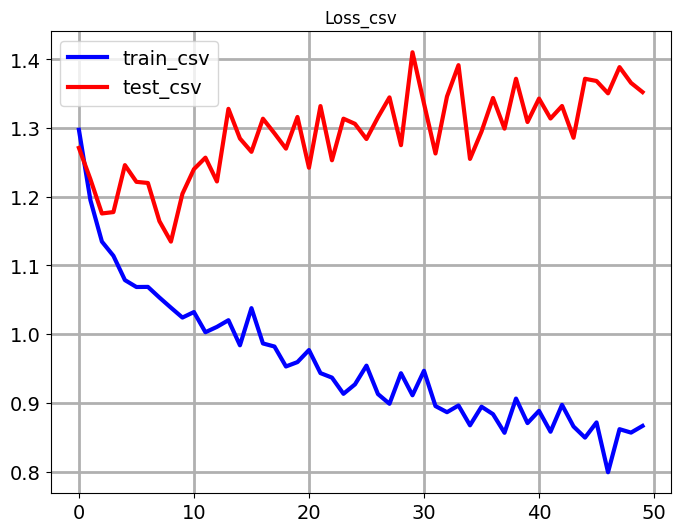

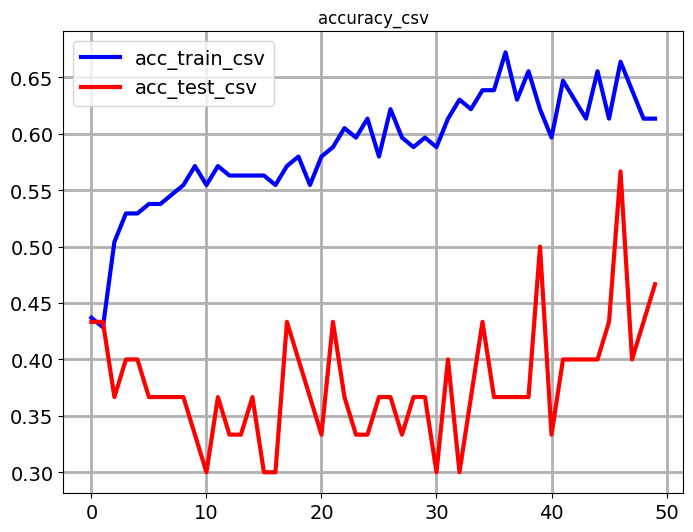

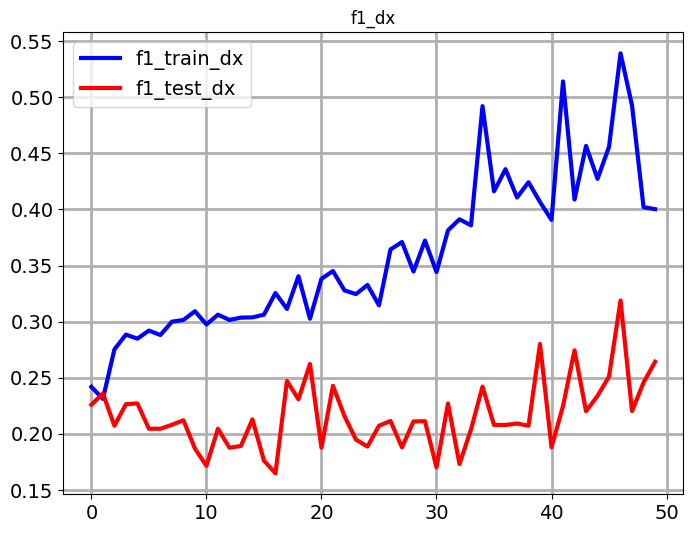

In [7]:
# 学習曲線 (損失関数) 診断モデル
plt.figure(figsize=(8,6))
plt.plot(loss_list_csv,label='train_csv', lw=3, c='b')
plt.plot(loss_list_test_csv,label='test_csv', lw=3, c='r')
plt.title('Loss_csv')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

# 学習曲線 (accuracy)
plt.figure(figsize=(8,6))
plt.plot(acc_csv,label='acc_train_csv', lw=3, c='b')
plt.plot(acc_test_csv,label='acc_test_csv', lw=3, c='r')
plt.title('accuracy_csv')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

# 学習曲線 (f1)
plt.figure(figsize=(8,6))
plt.plot(f1s_csv,label='f1_train_dx', lw=3, c='b')
plt.plot(f1s_test_csv,label='f1_test_dx', lw=3, c='r')
plt.title('f1_dx')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

30
Confusion matrix, without normalization
[[0 1 0 0]
 [0 0 1 5]
 [0 0 5 7]
 [0 0 6 5]]


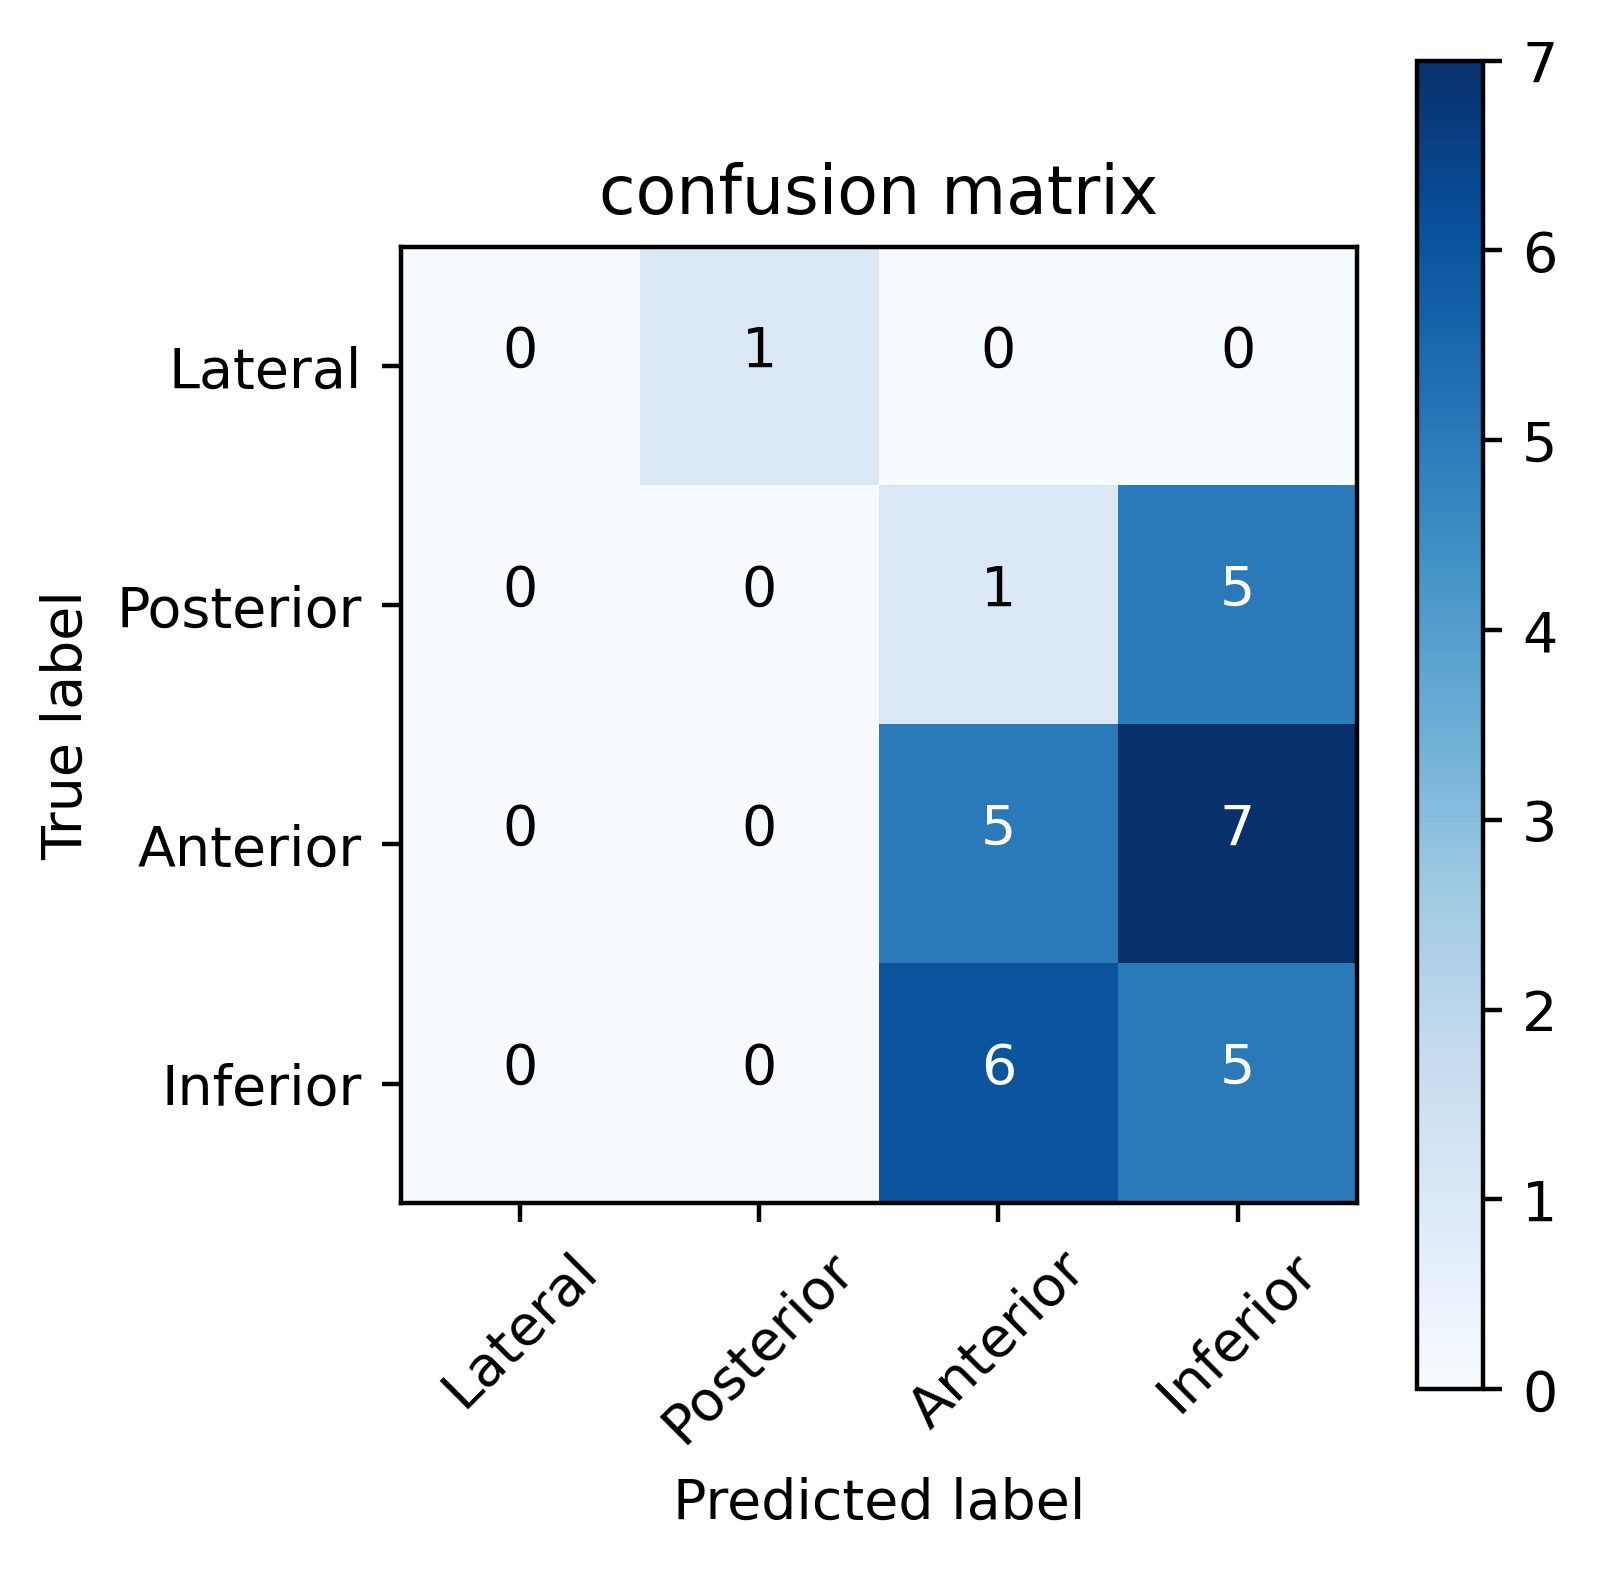

In [8]:
# Confusion matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
           """
           This function prints and plots the confusion matrix.
           Normalization can be applied by setting `normalize=True`.
           """
           if normalize:
               cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
               print("Normalized confusion matrix")
           else:
               print('Confusion matrix, without normalization')
           print(cm)
           plt.imshow(cm, interpolation='nearest', cmap=cmap)
           plt.title(title)
           plt.colorbar()
           tick_marks = np.arange(len(classes))
           plt.xticks(tick_marks, classes, rotation=45)
           plt.yticks(tick_marks, classes)
           fmt = '.2f' if normalize else 'd'
           thresh = cm.max() / 2.
           for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
               plt.text(j, i, format(cm[i, j], fmt),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")
           plt.tight_layout()
           plt.ylabel('True label')
           plt.xlabel('Predicted label')
           #plt.savefig(output_file)

print(len(pred_csv))

labels_csv=[0,1,2,3]
label2_csv=['Lateral','Posterior', 'Anterior', 'Inferior']
cnf_matrix=confusion_matrix(label_csv,pred_csv,labels=labels_csv)
title="confusion matrix"
plt.figure(figsize=(4,4),dpi=400)
plot_confusion_matrix(cnf_matrix, classes=label2_csv,title=title)
plt.show()